In [1]:
import sys
sys.path.append('..//')

import jax
import numpy as np
import jax.numpy as jnp
import scipy
from functools import partial
from jax.test_util import check_grads
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin
from scipy.optimize import minimize
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

from parsmooth._base import MVNStandard, FunctionalModel, MVNSqrt
from parsmooth.linearization import cubature, extended, gauss_hermite
from parsmooth.methods import iterated_smoothing
from bearings_utils import make_parameters
from bearing_data import get_data, inverse_bearings


In [2]:
linearization_method = extended

s1 = jnp.array([-1., 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
dt = 0.01  # discretization time step
qc = 0.1  # discretization noise
qw = 0.1  # discretization noise

r_true = 0.05

T = 50
_, true_states, ys = get_data(x0, dt, r_true, T, s1, s2)
Q, _, observation_function, transition_function = make_parameters(qc, qw, r_true, dt, s1, s2)

chol_Q = jnp.linalg.cholesky(Q)
# chol_R = jnp.linalg.cholesky(R)

m0 = jnp.array([2., 0, 0, 0, 0])
P0 = jnp.diag(jnp.array([0.5**2, 0.5**2, 0.5**2, 0.5**2, 1.]))
chol_P0 = scipy.linalg.cholesky(P0)

init = MVNStandard(m0, P0)
chol_init = MVNSqrt(m0, chol_P0)

initial_states =  MVNStandard(jnp.repeat(jnp.array([[0.4, 0.15, 0.9, 1, 1]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))
initial_states_sqrt = MVNSqrt(jnp.repeat(jnp.array([[0.4, 0.15, 0.9, 1, 1]]),T + 1, axis=0),
                              jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T + 1, axis=0))


sqrt_transition_model = FunctionalModel(transition_function, MVNSqrt(jnp.zeros((5,)), chol_Q))
transition_model = FunctionalModel(transition_function, MVNStandard(jnp.zeros((5,)), Q))


# true_states = true_states.astype(np.float64)

In [3]:
#standard
@jax.jit
def get_ell_std(prec_r):
    r = 1 / prec_r[0]
    R = jnp.diag(jnp.array([r ** 2, 0.1 ** 2]))
    observation_model = FunctionalModel(observation_function, MVNStandard(jnp.zeros((2,)), R))  
    
    _, ell = iterated_smoothing(ys, init, transition_model, observation_model,
                                               linearization_method, initial_states, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_std = jax.jit(jax.value_and_grad(get_ell_std))

In [ ]:
gpu_get_ell_std = jit(get_ell_std, backend="gpu")

In [8]:
def wrap_func_std(r):
    loss, grad_val = gpu_get_ell_std(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_std, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])

      fun: array(6332.15304817)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.81889024e+32])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 2
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([10.])

In [5]:
#square-root
@jax.jit
def get_ell_sqrt(prec_r):
    r = 1 / prec_r[0]
    chol_R = jnp.diag(jnp.array([r, 0.1]))
    observation_model_sqrt = FunctionalModel(observation_function, MVNSqrt(jnp.zeros((2,)), chol_R)) 
    
    _, ell = iterated_smoothing(ys, chol_init, sqrt_transition_model, observation_model_sqrt,
                                               linearization_method, initial_states_sqrt, True,
                                               criterion=lambda i, *_: i < 50,
                                               return_loglikelihood = True)
    return -ell

grad_ell_sqrt = jax.jit(jax.value_and_grad(get_ell_sqrt))


In [ ]:
gpu_get_ell_sqrt = jit(get_ell_sqrt, backend="gpu")

In [6]:
def wrap_func_sqrt(r):
    loss, grad_val = gpu_get_ell_sqrt(r)
    return np.array(loss, dtype=np.float64), np.array(grad_val, dtype=np.float64)
r0 = np.array([10.])
minimize(wrap_func_sqrt, r0, jac=True, method="L-BFGS-B", bounds=[(0, 100)])

      fun: array(-90.18252045)
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.54931878])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([13.21008244])

In [7]:
# jnp.savez("pe_ell_std_extended_T50",
#           ell_std_extended_T50 = np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])))

# jnp.savez("pe_ell_sqrt_extended_T50",
#           ell_sqrt_extended_T50 = np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])))

jnp.savez("pe_ell_std_extended_T50_par",
          ell_std_extended_T50_par = np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])))

jnp.savez("pe_ell_sqrt_extended_T50_par",
          ell_sqrt_extended_T50_par = np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])))




# jnp.savez("pe_ell_std_cubature_T50",
#           ell_std_cubature_T50 = np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])))

# jnp.savez("pe_ell_sqrt_cubature_T50",
#           ell_sqrt_cubature_T50 = np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])))

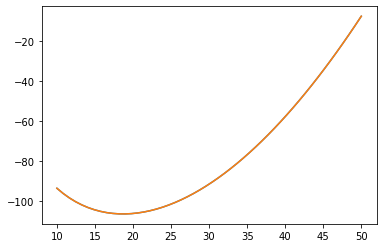

In [4]:
# with np.load("pe_ell_std_extended_T50.npz") as loaded:
#     ell_std_extended_T50 = loaded["ell_std_extended_T50"]
    
# with np.load("pe_ell_sqrt_extended_T50.npz") as loaded:
#     ell_sqrt_extended_T50 = loaded["ell_sqrt_extended_T50"]

with np.load("pe_ell_std_extended_T50_par.npz") as loaded:
    ell_std_extended_T50_par = loaded["ell_std_extended_T50_par"]
    
with np.load("pe_ell_sqrt_extended_T50_par.npz") as loaded:
    ell_sqrt_extended_T50_par = loaded["ell_sqrt_extended_T50_par"]

# with np.load("pe_ell_std_cubature_T50.npz") as loaded:
#     ell_std_cubature_T50 = loaded["ell_std_cubature_T50"]
    
# with np.load("pe_ell_sqrt_cubature_T50.npz") as loaded:
#     ell_sqrt_cubature_T50 = loaded["ell_sqrt_cubature_T50"]

# plt.plot(np.linspace(10, 50), ell_std_extended_T50)
# plt.plot(np.linspace(10, 50), ell_sqrt_extended_T50)

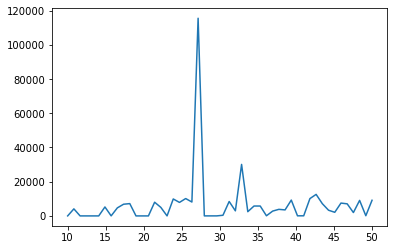

In [10]:
plt.plot(np.linspace(10, 50), 
         np.array(jax.vmap(lambda r: get_ell_std(r))(np.linspace(10, 50)[:, None])))
plt.plot(np.linspace(10, 50), 
         np.array(jax.vmap(lambda r: get_ell_sqrt(r))(np.linspace(10, 50)[:, None])))

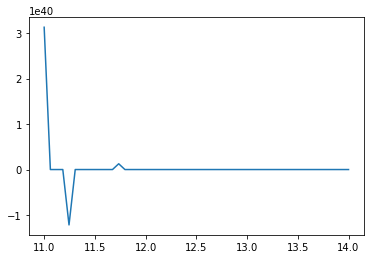

In [14]:
# plt.plot(np.linspace(10, 50), 
#          np.array(jax.vmap(lambda r: grad_ell_std(r))(np.linspace(10, 50)[:, None])[1]))
plt.plot(np.linspace(11, 14), 
         np.array(jax.vmap(lambda r: grad_ell_sqrt(r))(np.linspace(11, 14)[:, None])[1]))